In [9]:
import state_preparation.waveplates as wp
import state_preparation.utils as ut
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# States are uniformly distributed on the Bloch sphere for fixed theta sweeping phi
thetas = [np.pi/2, np.pi/4, np.pi/8]
phis = np.linspace(0, 2*np.pi, 20)

# Prepare the states
ket_h = qt.basis(2, 0)
ket_v = qt.basis(2, 1)

states = [[np.cos(theta/2)*ket_h + np.exp(1j*phi)*np.sin(theta/2)*ket_v for phi in phis] for theta in thetas]

In [11]:
# get the waveplate settings required for each state
settings = [[wp.get_hwp_qwp_from_target_state(state) for state in theta_states] for theta_states in states]

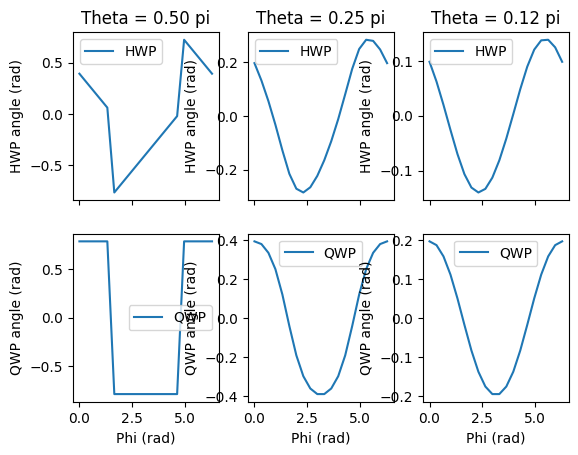

In [12]:
fig, ax = plt.subplots(2, len(thetas), sharex=True)
for i,theta in enumerate(thetas):
    # plot the waveplate settings
    ax[0, i].plot(phis, [s[0].real for s in settings[i]], label='HWP')
    ax[0, i].set_ylabel('HWP angle (rad)')
    ax[0, i].legend()
    ax[1, i].plot(phis, [s[1] for s in settings[i]], label='QWP')
    ax[1, i].set_ylabel('QWP angle (rad)')
    ax[1, i].legend()
    ax[1, i].set_xlabel('Phi (rad)')
    # label the theta
    ax[0, i].set_title(f'Theta = {theta / np.pi:.2f} pi')
plt.show()

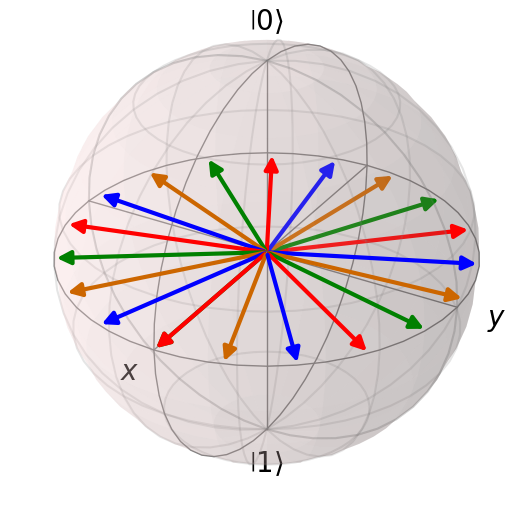

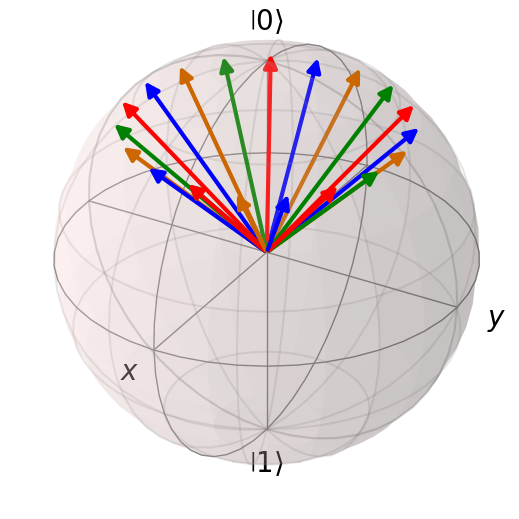

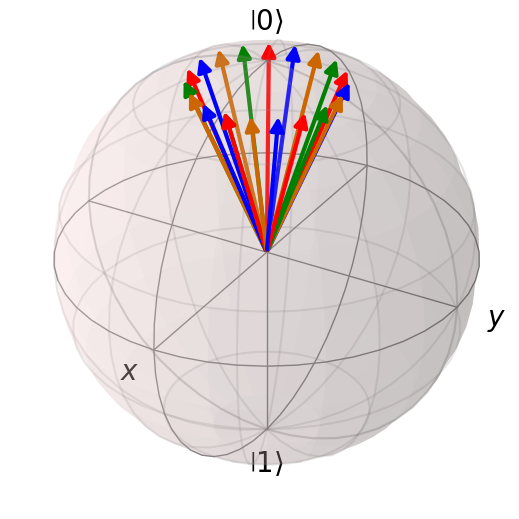

In [13]:
# get the waveplate matrices for each setting
matrices = [[[ut.hwp_matrix(s[0]), ut.qwp_matrix(s[1])] for s in settings[i]] for i in range(len(thetas))]

final_states = [[m[1]*m[0]*ket_h for m in matrices[i]] for i in range(len(thetas))]

for i in range(len(thetas)):
    b3d = qt.bloch.Bloch()
    b3d.add_states(final_states[i])
    b3d.title = f"Theta = {thetas[i]/np.pi:.2f} pi"
    
    b3d.show()

In [14]:
noise = [[0.5, 0.5], [0.5, -0.5], [-0.5, 0.5], [-0.5, -0.5]] # half a degree of noise
noise = np.multiply(np.pi/180, noise) # convert to radians

noisy_settings = [[[[s[0].real + n[0], s[1] + n[1]] for n in noise] for s in settings[i]] for i in range(len(thetas))]

In [15]:
# get the waveplate matrices for each setting
noisy_matrices = [[[[ut.hwp_matrix(s[0]), ut.qwp_matrix(s[1])] for s in setting] for setting in noisy_settings[i]] for i in range(len(thetas))]

noisy_final_states = [[[m[1]*m[0]*ket_h for m in matrices] for matrices in noisy_matrices[i]] for i in range(len(thetas))]



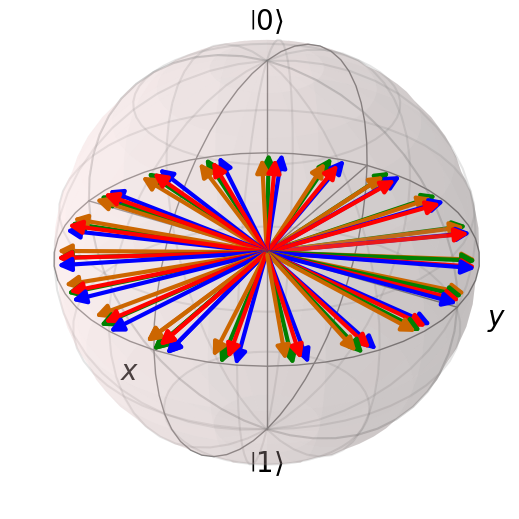

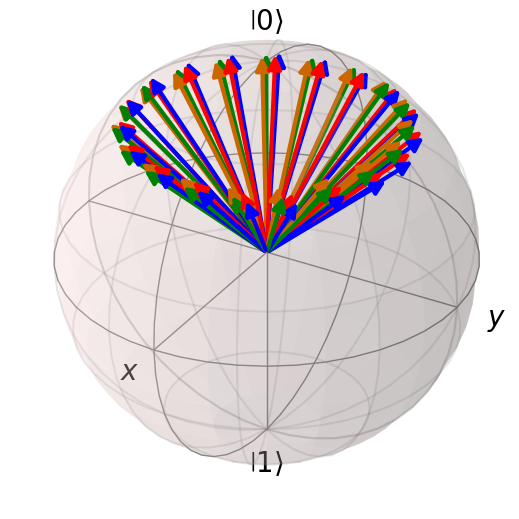

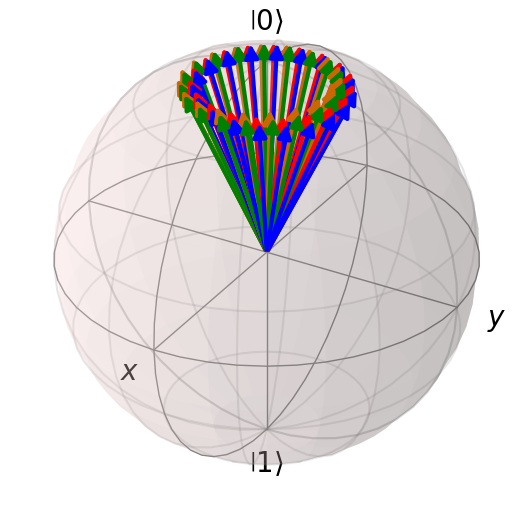

In [16]:
# plot the final states
for i in range(len(thetas)):
    b3d = qt.bloch.Bloch()
    b3d.add_states(np.concatenate(noisy_final_states[i]).ravel())
    b3d.show()